### Based on the data from the experiment, which of the two emails would you recommend for a larger scale campaign?


This is a typical A/B testing problem. There're two most popular ways to do the A/B testing - Frequentist's testing and Bayesian Testing. Let's try both methods and compare the results. 

Let's take a look at the data.

In [195]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [196]:
df = pd.read_csv('email_experiment.csv')

In [197]:
df.head()

,user_id,email,converted,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,123456,B,0,1.307944,-0.562787,1.039630,-2.908865,-2.115263,2.694800,-0.331587,0.815707,-0.324382,0.364599
1,123457,B,0,0.910389,-0.277683,-0.670094,-0.922280,-0.315424,-1.488813,-0.067852,-0.347947,1.367260,0.623631
2,123458,A,0,-1.340762,-0.918522,0.062053,1.049362,-1.540873,-0.372487,2.011240,1.394341,-1.092356,-0.256107
3,123459,B,0,-0.342582,0.969356,0.626722,0.138985,-1.008952,-0.867862,0.305326,0.616450,0.248013,-0.001253
4,123460,A,0,-0.926935,-1.722320,-2.290512,0.511226,-0.386015,-1.395568,-1.054296,0.239869,1.349215,-1.313154


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
user_id      1000 non-null int64
email        1000 non-null object
converted    1000 non-null int64
x1           1000 non-null float64
x2           1000 non-null float64
x3           1000 non-null float64
x4           1000 non-null float64
x5           1000 non-null float64
x6           1000 non-null float64
x7           1000 non-null float64
x8           1000 non-null float64
x9           1000 non-null float64
x10          1000 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 101.7+ KB


The data is tidy and clean, and for the first question, we only need the 'user_id', 'email', and 'converted' features from the dataset.

In [199]:
columns = ['x'+str(n) for n in range(1,11)]
df_test = df.drop(columns, axis = 1)

A = df_test.query('email == "A"')
B = df_test.query('email == "B"')

In [200]:
A.shape, B.shape

((406, 3), (594, 3))

In [201]:
A.user_id.nunique(), B.user_id.nunique()

(406, 594)

#### Frequentist A/B Testing

First off, let's confirm the metrics.  
In this case, we need to figure out which email campaign (A or B) is more effective at driving Basic to Pro conversions. Therefore, conversion rate is the metric we care about to compare the effectiveness of the campaign.  

Now that we have our metrics, we need to set up the Null and Alternative hypothesis. At the same time, we choose $\alpha$ = 0.05 as the significant level.

$$H_0: CVR_B - CVR_A \leq 0 $$
$$H_1: CVR_B - CVR_A > 0 $$

Then, let's take a look at the conversion rate of the two sample groups.

In [202]:
cvr_A = A.query('converted == 1').shape[0] / A.shape[0]
cvr_B = B.query('converted == 1').shape[0] / B.shape[0]

In [203]:
cvr_A, cvr_B

(0.09113300492610837, 0.10437710437710437)

Now we can see that Group A's conversian rate(0.0911) is higher than Group B's(0.1044). It looks like Group B is more effective than Group A. However, we need to see if the result is statistically significant!  
And let's take a look at the difference. 

In [204]:
obs_diff = cvr_B - cvr_A
obs_diff

0.013244099450996

In [205]:
diff = []
for _ in range(10000):
    boot_sample = df_test.sample(df_test.shape[0], replace = True) #bootstrap the sample to 
    a_boot = boot_sample.query('email == "A"')
    b_boot = boot_sample.query('email == "B"')
    cvr_A = a_boot.query('converted == 1').shape[0] / A.shape[0]
    cvr_B = b_boot.query('converted == 1').shape[0] / B.shape[0]
    diff.append(cvr_B - cvr_A)

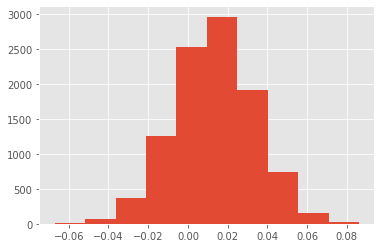

In [206]:
plt.hist(diff);

In [207]:
diff = np.array(diff)
null_vals = np.random.normal(0, diff.std(), diff.size)

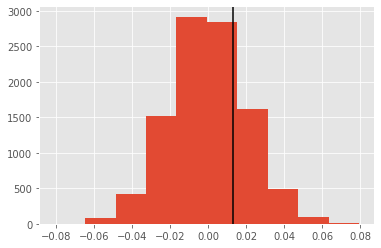

In [208]:
plt.hist(null_vals)
plt.axvline(x = obs_diff, color = 'black');

In [220]:
print('The p-value is {}.'.format((null_vals > obs_diff).mean()))

The p-value is 0.252.


We can see that p-value is larger than 0.05. Therefore,  we fail to reject the Null hypothesis.   
We cannot say that Campaign B is more effective than Campaign A.

#### Baysian A/B Testing

Baysian Testing is based on the Baysian inference. 

$$P(H_i\ |\ x) = \frac{P(x\ |\ H_i) P(H_i)}{P(x)}$$


In this case, let's start with the uniform prior, assuming that the probability of getting 0 or 1 is equally likely before we got any data.

In [210]:
x = np.arange(0, 1.01, 0.01)

In [211]:
y = stats.uniform(0, 1).pdf(x)

In [212]:
def plot_with_fill(x, y, label):
    lines = plt.plot(x, y, label=label, lw=2)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_c())
    plt.legend(loc='best')

In [213]:
def get_pdf(x, group):
    ''' The function will return the pdf for a given beta distribution
    
    x : array of x values
    group : array cooresponding to the group in question

    '''
    alpha = sum(group)
    beta = len(group) - alpha
    return stats.beta(a=alpha, b=beta).pdf(x)

In [221]:
y_prior = stats.beta(a=1, b=1).pdf(x)

In [222]:
y_A = get_pdf(x, A.converted)
y_B = get_pdf(x, B.converted)

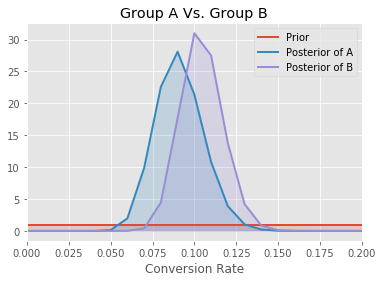

In [223]:
plot_with_fill(x, y_prior, 'Prior')

plot_with_fill(x, y_A, 'Posterior of A')
plot_with_fill(x, y_B, 'Posterior of B')

plt.xlim(0, 0.2)
plt.title('Group A Vs. Group B')
plt.xlabel('Conversion Rate');

In [224]:
n_trials = 100000

# First let's take 10000 draws for each like so...
a_sample = np.random.beta(a=sum(A.converted), b=A.shape[0]-sum(A.converted), size=n_trials)
b_sample = np.random.beta(a=sum(B.converted), b=B.shape[0]-sum(B.converted), size=n_trials)


# Now let's get the percentage of the time that the draw from Site B
# is larger than the draw from Site A
prob = (b_sample > a_sample).mean()
print(
    'There is a {:.3f} probability that Group B is better than Group A\n'.format(prob))

There is a 0.759 probability that Group B is better than Group A



This is called a credible interval. 1 - credible interval is similar to the p-value in the frequenist method. Here it is 1 - 0.759 = 0.241, which is quite close to the p-value we got. 
Still, the conclusion is that we cannot tell that Group B is better than Group A. 

In all, Frequentist and Bayesian testings are just two different types of testings based on different statistical theories. Personally I prefer Bayesian testing since you can always update the posterior probability when more data is collected.  

### We're also interested in predicting whether or not a user will convert to Pro based on user characteristics (i.e. the x variables in the data file). Which of the ten variables would you recommend that we use for predicting conversion?

Now we know that there are 10 features in the data, and the label is binary, so this is classifiction problem. 


####  EDA

In [303]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

In [304]:
df2 = df.drop(['email','user_id'], axis = 1)

In [305]:
df2.head()

,converted,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0,1.307944,-0.562787,1.039630,-2.908865,-2.115263,2.694800,-0.331587,0.815707,-0.324382,0.364599
1,0,0.910389,-0.277683,-0.670094,-0.922280,-0.315424,-1.488813,-0.067852,-0.347947,1.367260,0.623631
2,0,-1.340762,-0.918522,0.062053,1.049362,-1.540873,-0.372487,2.011240,1.394341,-1.092356,-0.256107
3,0,-0.342582,0.969356,0.626722,0.138985,-1.008952,-0.867862,0.305326,0.616450,0.248013,-0.001253
4,0,-0.926935,-1.722320,-2.290512,0.511226,-0.386015,-1.395568,-1.054296,0.239869,1.349215,-1.313154


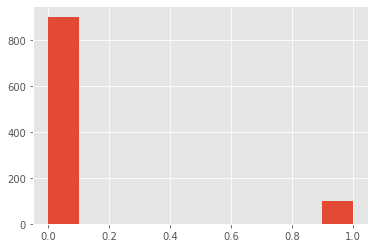

In [306]:
#let's check the data balance.

plt.hist(df2.converted);

In [308]:
df2['converted'].value_counts()

0    901
1     99
Name: converted, dtype: int64

So we can tell that the data is imbalanced. Due to the fact that our sample size is merely 1000, the imbalance could be a problem if we don't do anything before running the model. 

Common method to create a balanced dataset includes manually oversampling the minority sub-sample, undersampling the majority sub_sample, or using SMOTE. 

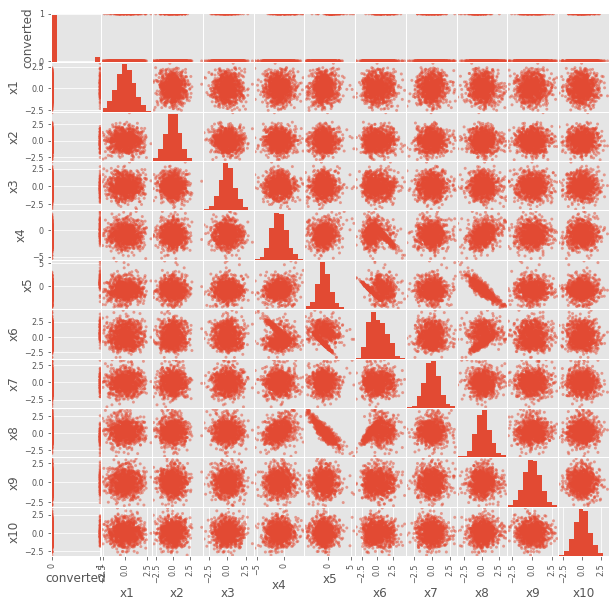

In [309]:
pd.plotting.scatter_matrix(df2, figsize = (10,10));

It looks like that there is multicolliearity. Let's take a look at the heatmap of corrolation. 

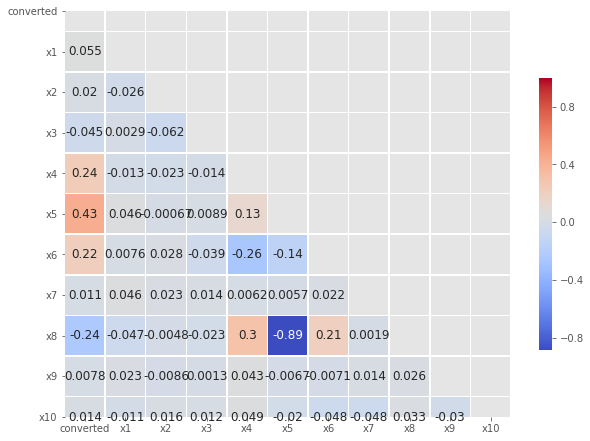

In [317]:
corr = df2.corr()

fig, ax = plt.subplots(figsize=(10,10))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

cmap = sns.cubehelix_palette(8)
sns.heatmap(corr, mask=mask, 
            cmap='coolwarm', 
            square = True, 
            linewidths=.5, 
            annot = True, 
            annot_kws = {"size": 12}, 
            cbar_kws={"shrink": .5})

Since x5 and x8 are highly corrolated, let's drop one of them. (x5)

In [318]:
df2.drop(['x5'], axis = 1, inplace = True)

#### Modeling. 
Let's try Logistic Regression and Random Forest Classifier.

In [319]:
X = df2.drop(['converted'], axis = 1)
y = df2.converted

In [320]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

In [321]:
smt = SMOTE(random_state=42) #use SMOTE to re-sample the imbalanced data.
X_train, y_train = smt.fit_sample(X_train, y_train)

In [322]:
lr = LogisticRegression(penalty='l1', fit_intercept=True, random_state=42)

lr.fit(X_train, y_train)

/Users/stuartxu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [277]:
y_pred = lr.predict(X_test)

In [278]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94       360
           1       0.46      0.78      0.58        40

    accuracy                           0.89       400
   macro avg       0.72      0.84      0.76       400
weighted avg       0.92      0.89      0.90       400



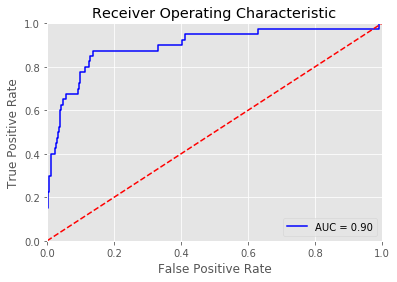

In [279]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

Not bad... now let's check out the features!

In [280]:
lr.coef_

array([[ 0.02963713,  0.01881263, -0.53883193,  1.97977912,  1.66863867,
        -0.14635722, -2.95652672, -0.06234635,  0.        ]])

In [281]:
df_lr_coef = pd.DataFrame({'features': df2.drop('converted', axis = 1).columns, 'coef': np.abs(lr.coef_).reshape(9,)})

In [282]:
df_lr_coef.sort_values(by='coef', ascending=False, inplace=True)

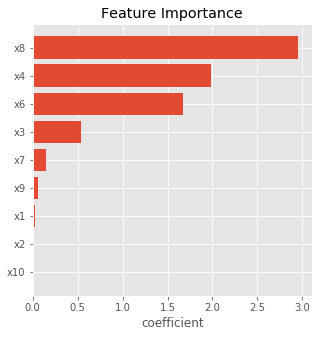

In [283]:
fig, ax = plt.subplots(figsize=(5,5))


y_pos = np.arange(len(X.columns))
coef_ = df_lr_coef.coef

ax.barh(y_pos, coef_, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_lr_coef.features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('coefficient')
ax.set_title('Feature Importance');

Therefore, the logistic regression told us that x8, x4 and x6 are the most importance features. The coefficients of logistic regression is an indicator of the feature importance since a regression coefficient describe the size and direction of the relationship between a predictor and the response variable.    

In this case, for example, since the coef of x8 is -2.96, we can say that the natural log of the odds decrease by 2.96 for each unit increase. 

Another model we can try is Random Forest.   
In the 'tree' machine learning models, each feature is considered at each split. For each feature, we sum the resulting change in RSS at the nodes which use that feature for splitting. At the end, we will have each feature and the cumulative decrease in RSS associated with that feature. The features with the largest cumulative decrease are the "most important" in this regression.

In [292]:
rf = RandomForestClassifier(max_depth=2, n_estimators=100, oob_score=True, random_state=0)

In [293]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [294]:
y_hat = rf.predict(X_test)

In [295]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       360
           1       0.33      0.78      0.46        40

    accuracy                           0.82       400
   macro avg       0.65      0.80      0.67       400
weighted avg       0.91      0.82      0.85       400



In [296]:
rf.feature_importances_

array([0.01922285, 0.04619238, 0.01954952, 0.2682678 , 0.38216271,
       0.01764235, 0.23501037, 0.0044975 , 0.00745452])

In [289]:
df_rf_imp = pd.DataFrame({'features': df2.drop('converted', axis = 1).columns, 'importance': rf.feature_importances_})

In [290]:
df_rf_imp.sort_values(by='importance', ascending=False,inplace=True)

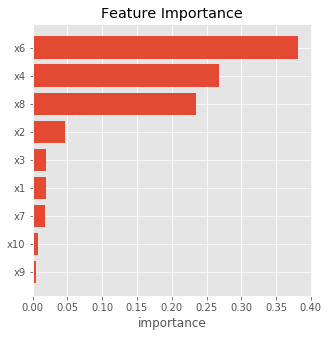

In [297]:
fig, ax = plt.subplots(figsize=(5,5))

y_pos = np.arange(len(X.columns))
importance = df_rf_imp.importance

ax.barh(y_pos, importance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_rf_imp.features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('importance')
ax.set_title('Feature Importance');

Now we can tell that x6, x4, and x8 are the most important features if we run a Random Forest model. 

Here we just tried two simple classification models, and we used all the features except for x5 due to it's high correlation with x8. 

The feature importance rankings in the conclusion would potential help the business team to make decisions. 